In [1]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import json
from collections import Counter

api = wandb.Api()

In [2]:
runs = api.runs("qba/rehersal Alexnet MNIST Task IL tr-t split v2")

In [3]:
runs_list = []

for run in runs:
    runs_list.append(run.config)

df = pd.DataFrame(runs_list).astype(str)

df

,setup,epochs,dataset,project,pretraining,architecture,learning_rate,rehearsal_dataset,batch_size_rehearsal
0,task IL,5,CIFAR10,rehersal Alexnet MNIST Task IL tr-t split v2,True,SmallAlexNetTasklIL,0.001,stat-spectrum_color_wmm,128.0
1,task IL,5,CIFAR10,rehersal Alexnet MNIST Task IL tr-t split v2,True,SmallAlexNetTasklIL,0.001,stat-spectrum_color_wmm,128.0
2,task IL,5,CIFAR10,rehersal Alexnet MNIST Task IL tr-t split v2,True,SmallAlexNetTasklIL,0.001,stat-spectrum_color_wmm,128.0
3,task IL,5,CIFAR10,rehersal Alexnet MNIST Task IL tr-t split v2,True,SmallAlexNetTasklIL,0.001,stat-spectrum_color_wmm,128.0
4,task IL,5,CIFAR10,rehersal Alexnet MNIST Task IL tr-t split v2,True,SmallAlexNetTasklIL,0.001,stat-spectrum_color_wmm,128.0
...,...,...,...,...,...,...,...,...,...
102,task IL,5,CIFAR10,nan,nan,SmallAlexNetTasklIL,0.01,dead_leaves-mixed,nan
103,task IL,5,CIFAR10,nan,nan,SmallAlexNetTasklIL,0.01,dead_leaves-mixed,nan
104,task IL,5,CIFAR10,nan,nan,SmallAlexNetTasklIL,0.01,dead_leaves-mixed,nan
105,task IL,5,CIFAR10,nan,nan,SmallAlexNetTasklIL,0.01,dead_leaves-mixed,nan


In [4]:
UID = ['rehearsal_dataset', 'batch_size_rehearsal', 'pretraining', 'learning_rate']
df['UID'] = ''

for c in UID:
    df['UID'] += df[c].astype(str)+';'

In [5]:
unique_UID = df['UID'].unique()
unique_run_params = []

for uuid in unique_UID:
    unique_run_params.append(uuid.split(';')[:4])
unique_run_params

[['stat-spectrum_color_wmm', '128.0', 'True', '0.001'],
 ['stat-wmm', '128.0', 'False', '0.001'],
 ['stat-wmm', '128.0', 'True', '0.001'],
 ['None', '128.0', 'False', '0.001'],
 ['stat-wmm', '256.0', 'True', '0.01'],
 ['stat-wmm', '128.0', 'True', '0.01'],
 ['stat-wmm', '64.0', 'nan', '0.01'],
 ['stat-wmm', '16.0', 'nan', '0.01'],
 ['stat-wmm', '32.0', 'nan', '0.01'],
 ['', 'nan', 'nan', '0.01'],
 ['stylegan-random', 'nan', 'nan', '0.01'],
 ['stylegan-highfreq', 'nan', 'nan', '0.01'],
 ['stat-wmm', 'nan', 'nan', '0.01'],
 ['stat-spectrum_color_wmm', 'nan', 'nan', '0.01'],
 ['stat-spectrum_color', 'nan', 'nan', '0.01'],
 ['stat-spectrum', 'nan', 'nan', '0.01'],
 ['dead_leaves-textures', 'nan', 'nan', '0.01'],
 ['dead_leaves-squares', 'nan', 'nan', '0.01'],
 ['dead_leaves-oriented', 'nan', 'nan', '0.01'],
 ['dead_leaves-mixed', 'nan', 'nan', '0.01']]

In [6]:
unique_run_settings_idxs = []

for run_param in unique_run_params:
    idx = pd.Series([True for _ in range(len(df))])
    for c, v in zip(UID, run_param):
        idx = (idx) & (df[c] == v)
    unique_run_settings_idxs.append(df[idx].index)

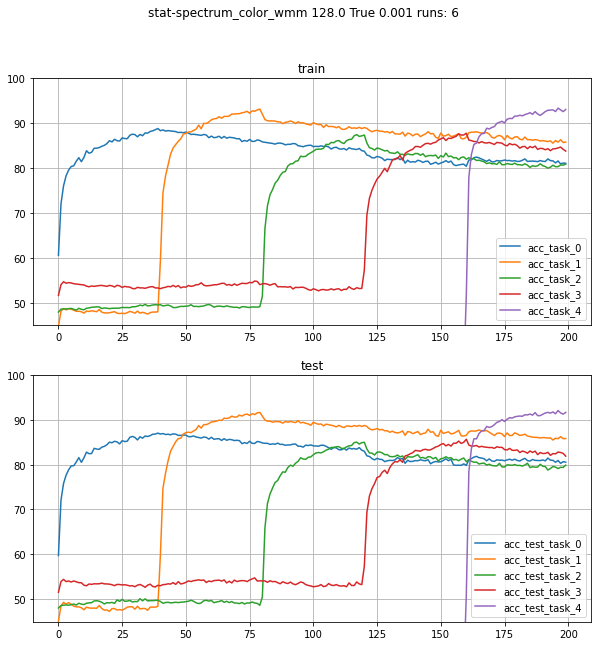

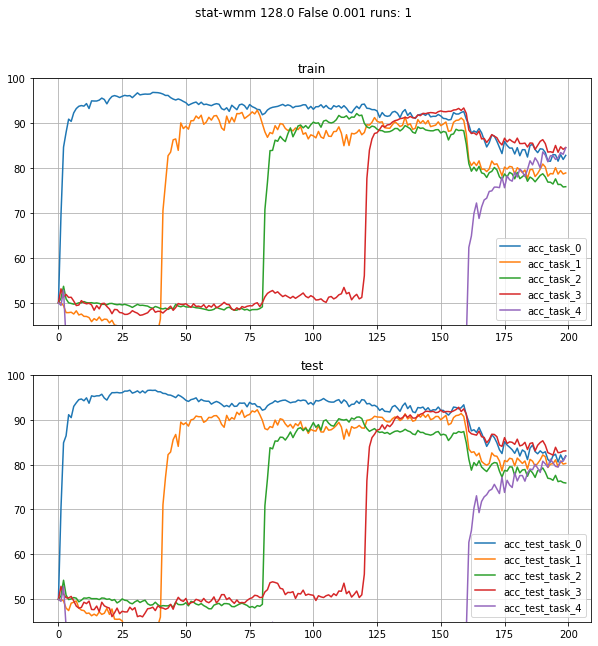

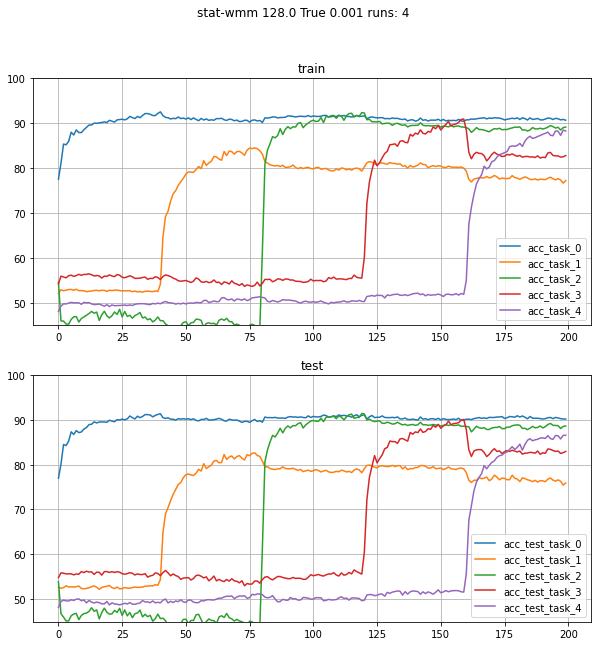

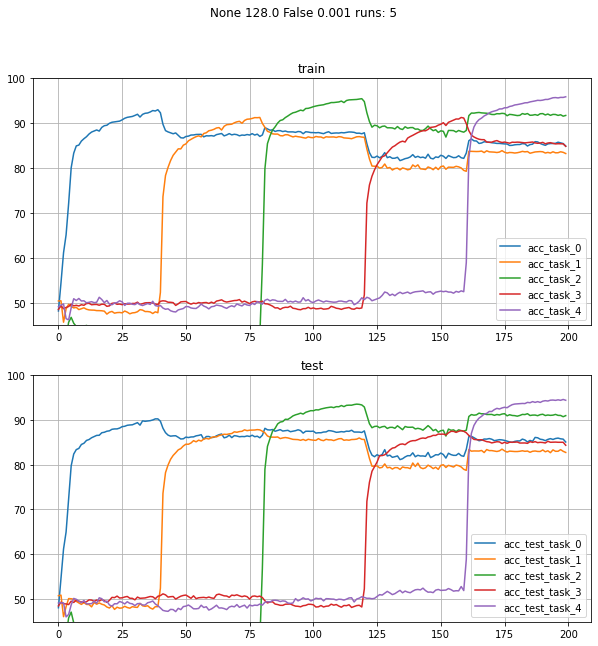

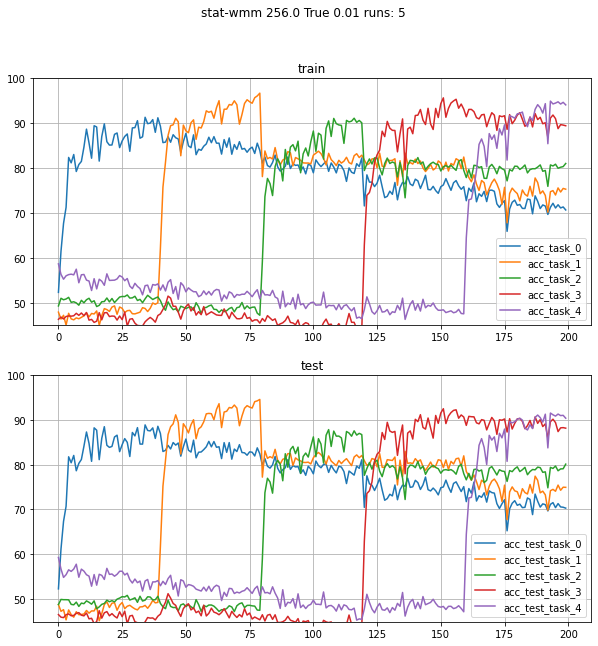

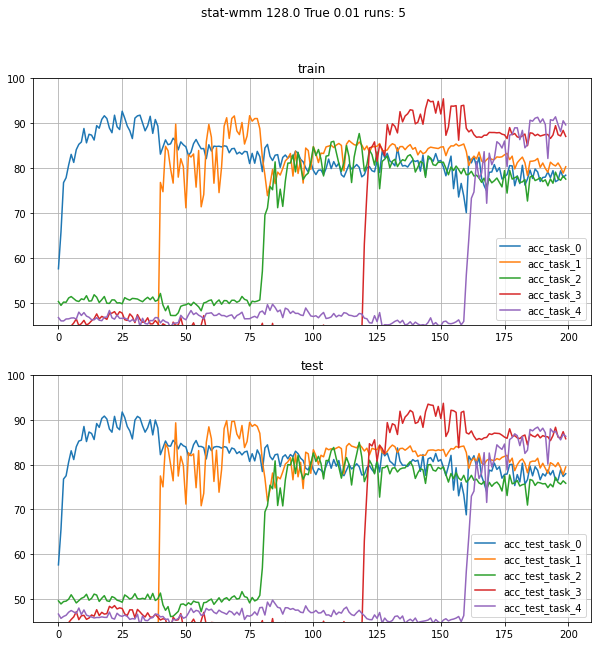

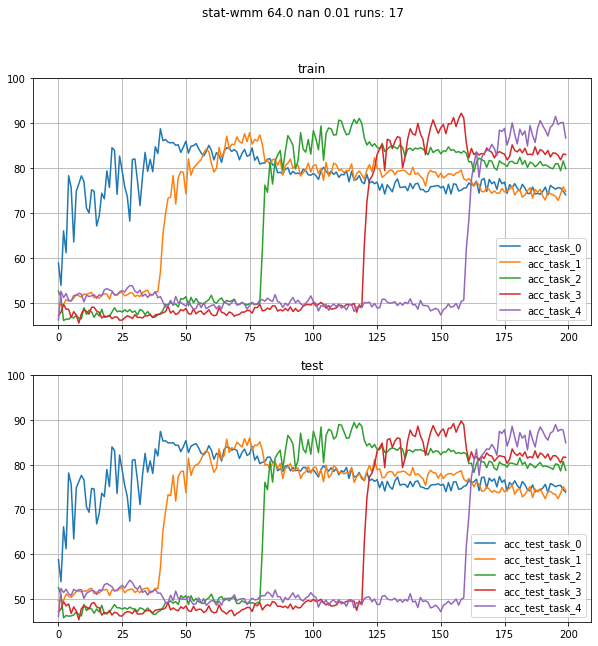

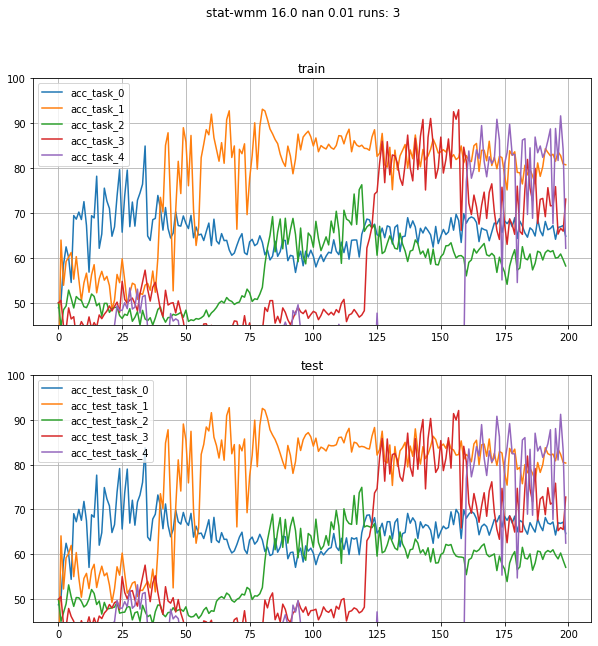

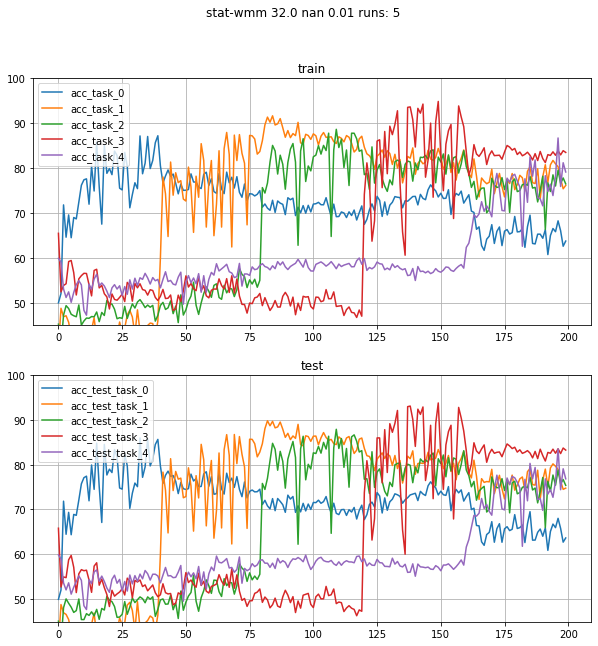

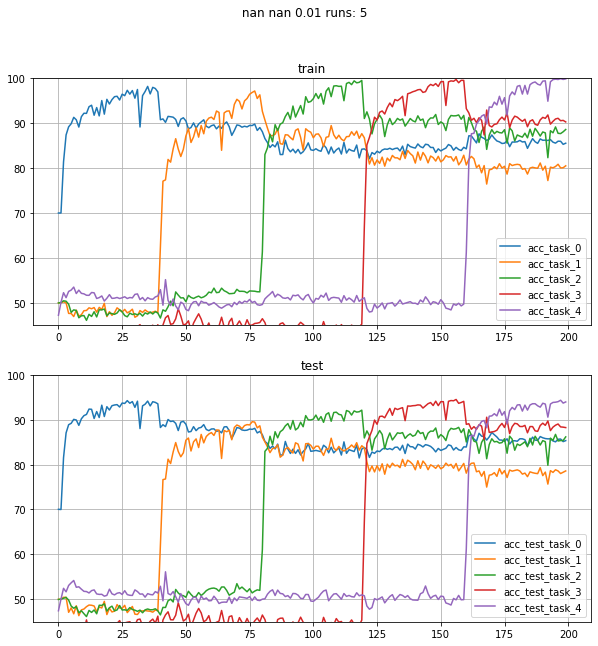

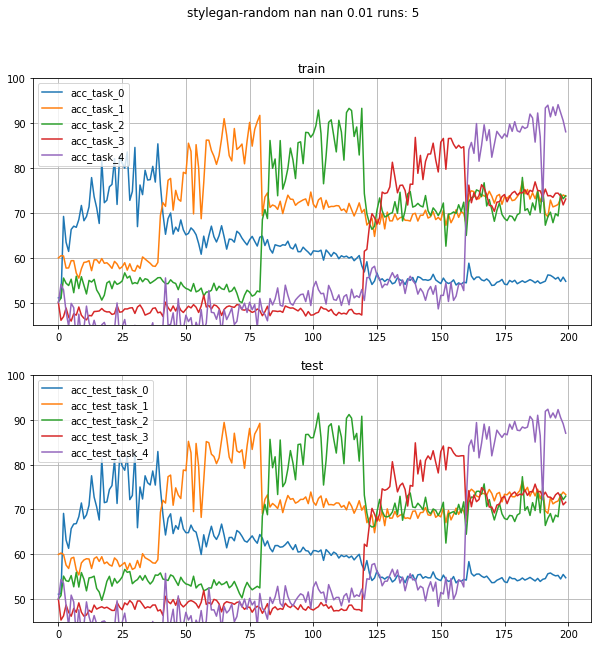

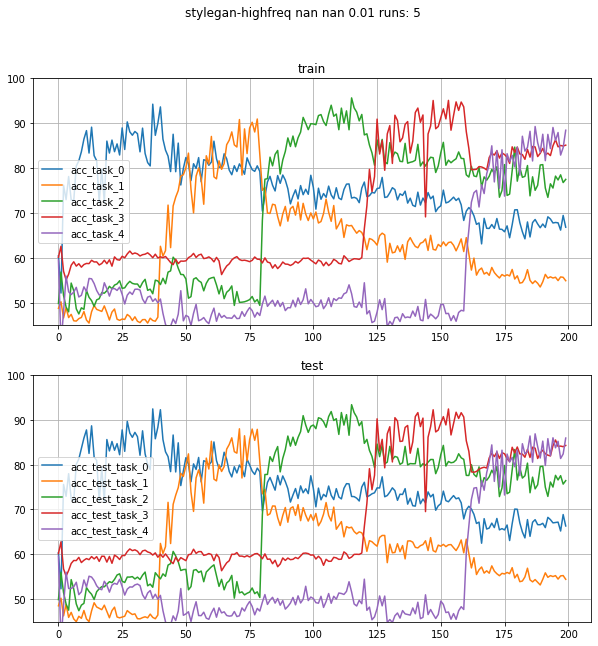

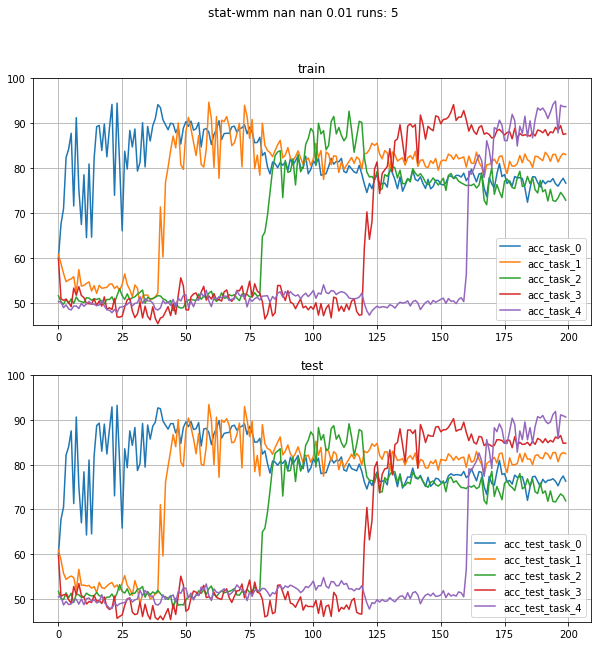

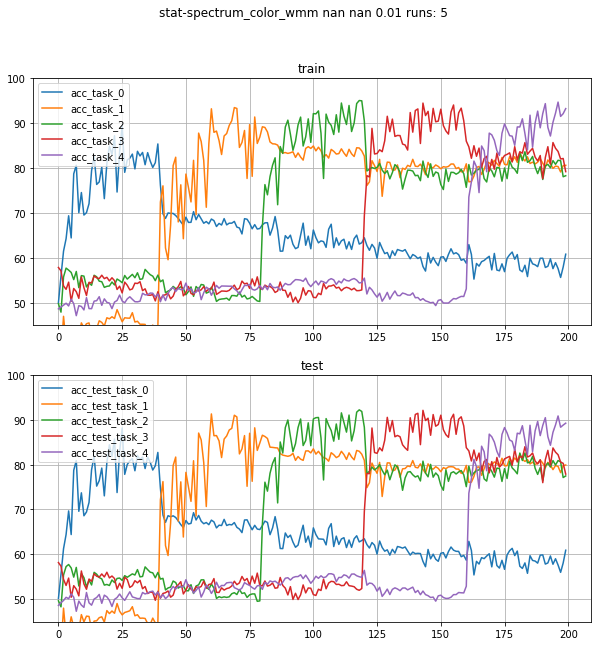

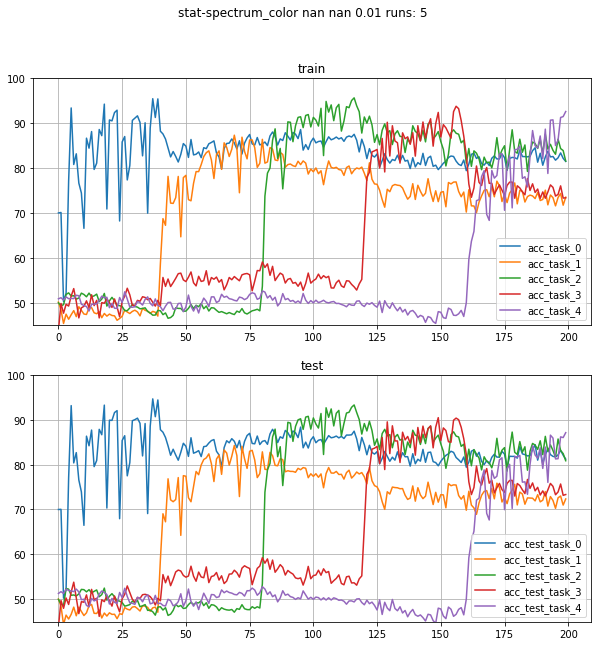

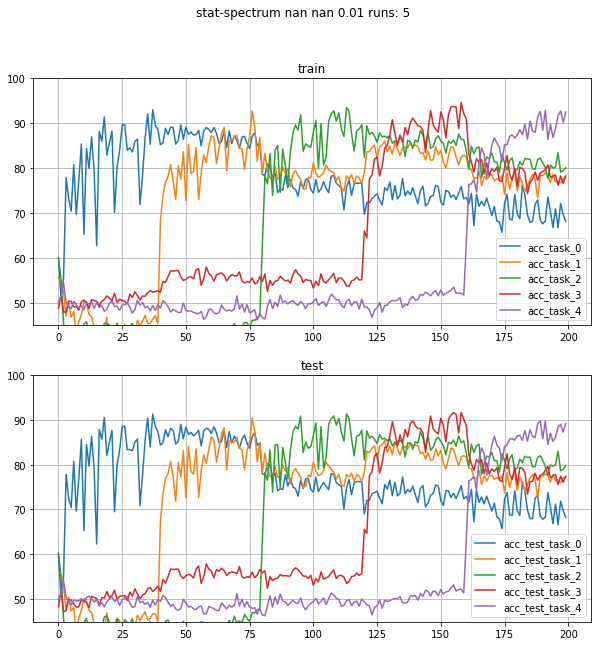

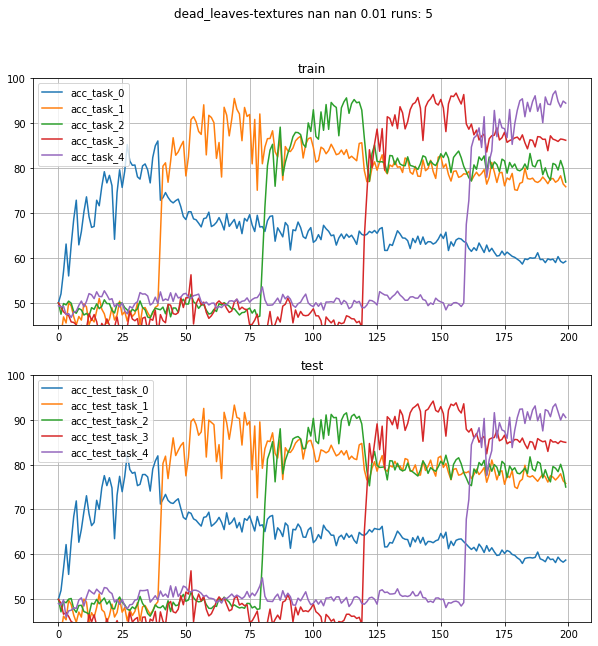

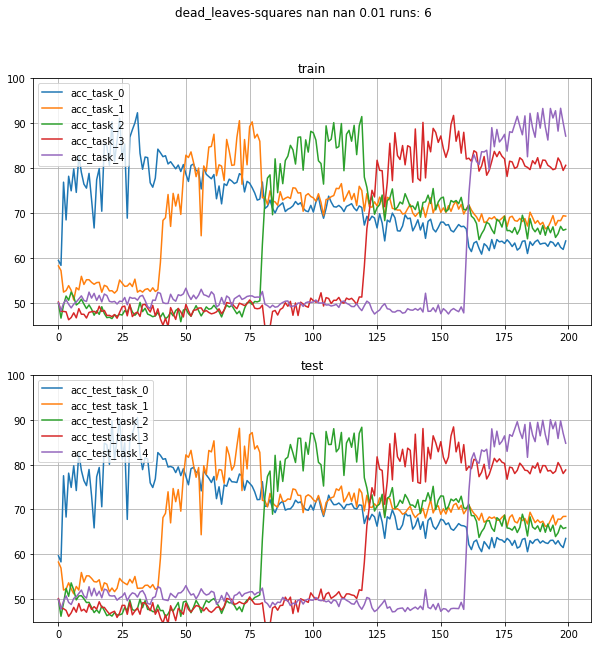

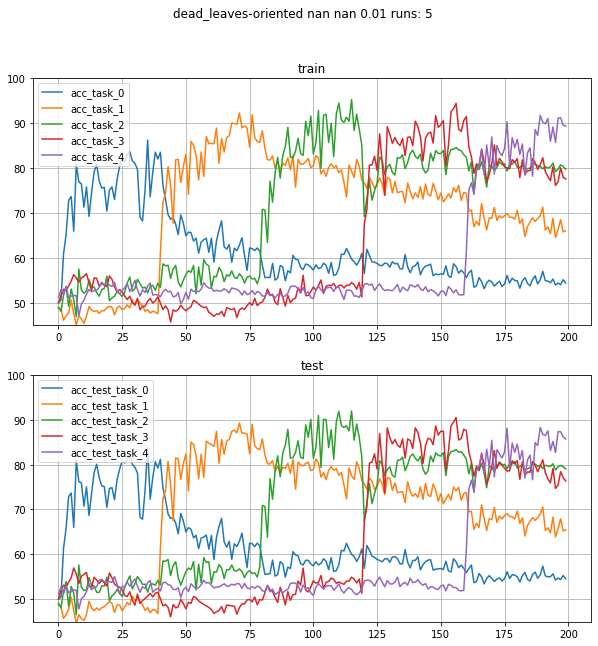

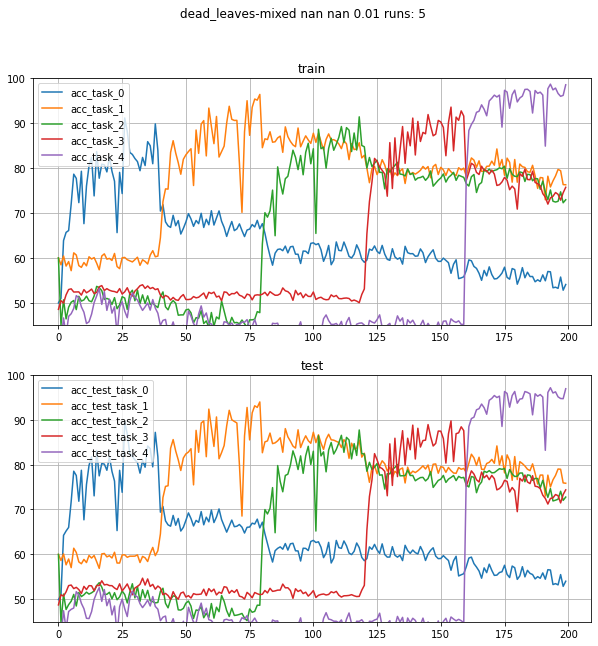

In [7]:
acc_col = ['acc_task_0', 'acc_task_1', 'acc_task_2', 'acc_task_3', 'acc_task_4']
acc_test_col = ['acc_test_task_0', 'acc_test_task_1', 'acc_test_task_2', 'acc_test_task_3', 'acc_test_task_4']

for unixe_idxs in unique_run_settings_idxs:
    df_train, df_test = pd.DataFrame(), pd.DataFrame()
    for run_idx in unixe_idxs.values:
        try:
            curr_run = runs[run_idx].history(100000)
            if len(df_train > 0):
                df_train += curr_run[acc_col].dropna().reset_index().drop(columns='index')
                df_test += curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
            else:
                df_train = curr_run[acc_col].dropna().reset_index().drop(columns='index')
                df_test = curr_run[acc_test_col].dropna().reset_index().drop(columns='index')
        except Exception as e:
            print(f"Error in run: {run_idx} Error: {e}")
    try:
        df_train /= len(unixe_idxs)
        df_test /= len(unixe_idxs)

        fig, ax = plt.subplots(2,1)
        fig.set_figheight(10)
        fig.set_figwidth(10)
        fig.suptitle(df.iloc[unixe_idxs]['UID'].iloc[0].replace(';',' ') + f"runs: {len(unixe_idxs)}", fontsize=12)
        df_train.plot(ax=ax[0], grid=True, ylim=[45, 100], title='train')
        df_test.plot(ax=ax[1], grid=True, ylim=[45, 100], title='test')
        plt.show()
    except Exception as e:
        print(f"Exception with ids: {unixe_idxs}, exception: {e}")